In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import torch
from utils import ood_scatter_plot, recon_var_plot, populate_layer_stats, comparative_mean_plot, comparative_var_plot, img_stat, disentangled_mean_plot
import danns_eg.densenet as densenets
import pickle

/home/mila/r/roy.eyono/.conda/envs/ffcv_eg/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mila/r/roy.eyono/.conda/envs/ffcv_eg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data
Loaded data


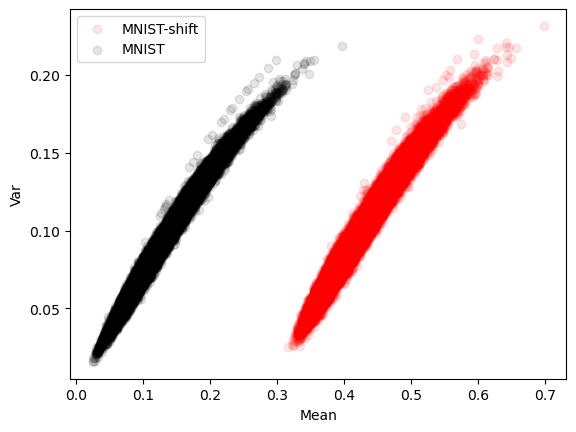

In [2]:
img_stat()

range(0, 50)


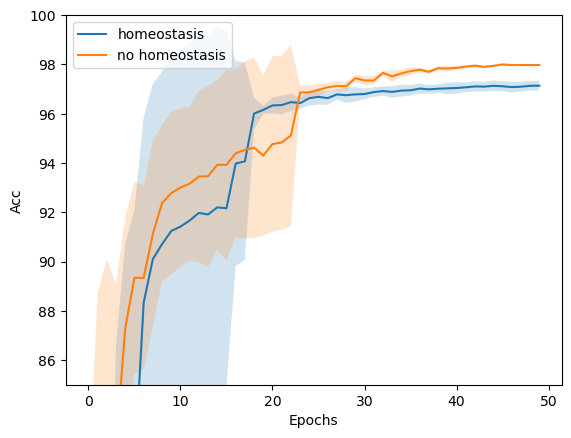

In [18]:
n = 5

homeo_arr = np.array([[]])
non_homeo_arr = np.array([[]])

for i in range(n):

    # Specify the file name
    file_name_homeo = f'res/homeo_dann_{i}_results.pkl'
    file_name_no_homeo = f'res/non_homeo_dann_{i}_results.pkl'

    # Open the file in binary read mode ('rb')
    with open(file_name_homeo, 'rb') as file:
        # Use pickle.load() to load the list from the file
        homeo = pickle.load(file)

    # Open the file in binary read mode ('rb')
    with open(file_name_no_homeo, 'rb') as file:
        # Use pickle.load() to load the list from the file
        no_homeo = pickle.load(file)

    if i == 0:
        homeo_arr = np.array([homeo["test_accs"]])
        non_homeo_arr = np.array([no_homeo["test_accs"]])
    else:
        homeo_arr = np.append(homeo_arr, [np.array(homeo["test_accs"])], axis=0)
        non_homeo_arr = np.append(non_homeo_arr, [np.array(no_homeo["test_accs"])], axis=0)

h = homeo_arr.mean(axis=0)
n_h = non_homeo_arr.mean(axis=0)
plt.plot(homeo_arr.mean(axis=0), label="homeostasis")
plt.fill_between(range(len(h)), h - homeo_arr.std(axis=0), h + homeo_arr.std(axis=0), alpha=0.2)
plt.plot(non_homeo_arr.mean(axis=0), label="no homeostasis")
plt.fill_between(range(len(n_h)), n_h - non_homeo_arr.std(axis=0), n_h + non_homeo_arr.std(axis=0), alpha=0.2)
plt.ylim(85, 100)
print(range(len(n_h)))
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()

In [19]:
# Specify the file name
file_name_homeo = 'res/homeo_dann_0_layers.pkl'
file_name_no_homeo = 'res/non_homeo_dann_0_layers.pkl'

# Open the file in binary read mode ('rb')
with open(file_name_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    homeo = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_no_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    no_homeo = pickle.load(file)

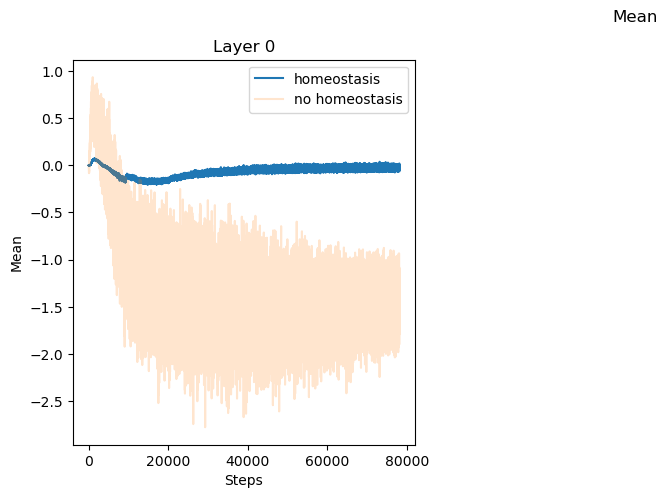

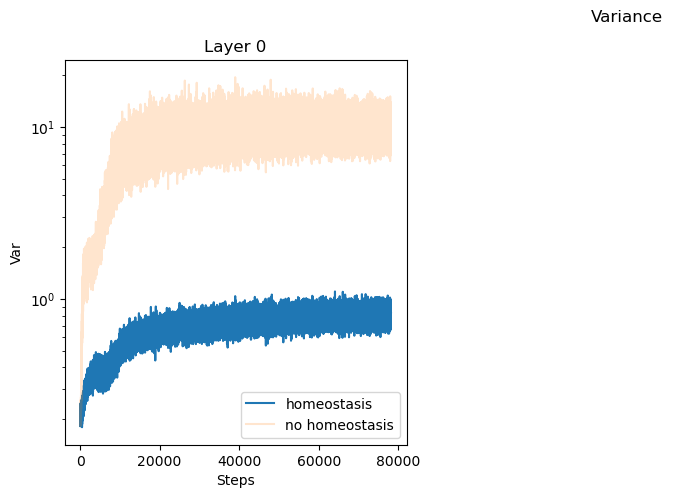

In [20]:
comparative_mean_plot(homeo, no_homeo, label1="homeostasis", label2="no homeostasis")
comparative_var_plot(homeo, no_homeo, label1="homeostasis", label2="no homeostasis")

In [2]:
homeo_model_state_dict = torch.load('res/homeo_dann_2.pt')
non_homeo_model_state_dict = torch.load('res/non_homeo_dann_2.pt')

In [3]:
input_dim = 784
num_class = 10
width=500
model_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=True)
model_homeo.load_state_dict(homeo_model_state_dict)
model_non_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=False)
model_non_homeo.load_state_dict(non_homeo_model_state_dict)

Homeostasis is True
Homeostasis is False


<All keys matched successfully>

Text(0, 0.5, 'Layer Variance')

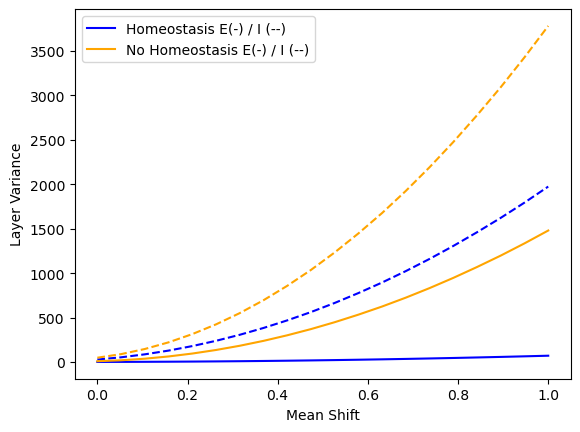

In [4]:
# Average this over a couple runs
variance_perturbation = False
x, mu, var, homeo_acc = disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
plt.plot(x, var, linestyle='--', color='blue')
x, mu, var, non_homeo_acc = disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
plt.plot(x, var,  linestyle='--', color='orange')
x, mu, var, _ = disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
plt.plot(x, var, label="Homeostasis E(-) / I (--)", linestyle='-', color='blue')
x, mu, var, _ = disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
plt.plot(x, var, label="No Homeostasis E(-) / I (--)", linestyle='-', color='orange')
plt.legend()
plt.xlabel("Variance Shift" if variance_perturbation else "Mean Shift")
plt.ylabel("Layer Variance")

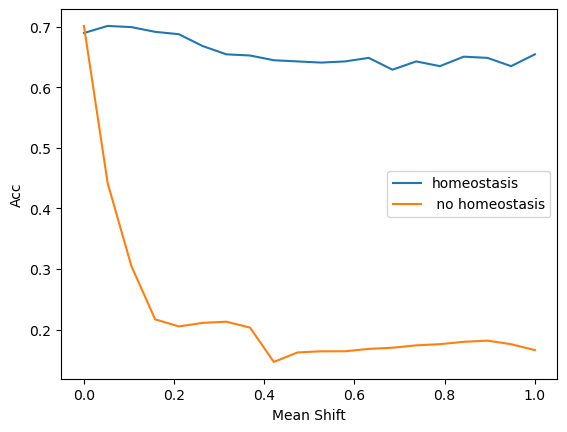

In [5]:
plt.plot(x, homeo_acc, label="homeostasis")
plt.plot(x, non_homeo_acc, label=" no homeostasis")
plt.ylabel("Acc")
plt.xlabel("Mean Shift")
plt.legend()

Text(0, 0.5, 'Layer Mean')

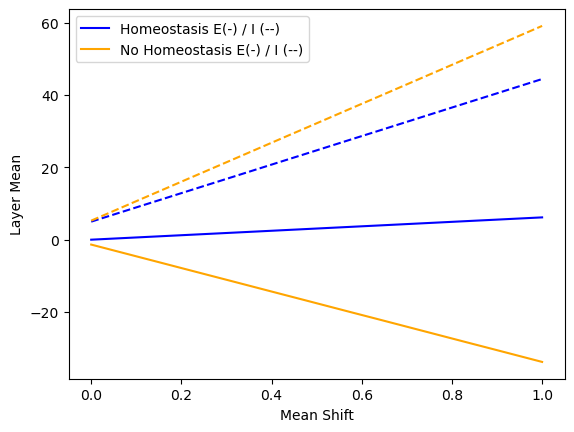

In [7]:
# Average this over a couple runs
variance_perturbation = False
x, mu, var, _ = disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
plt.plot(x, mu, linestyle='--', color='blue')
x, mu, var, _ = disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
plt.plot(x, mu,  linestyle='--', color='orange')
x, mu, var, _ = disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
plt.plot(x, mu, label="Homeostasis E(-) / I (--)", linestyle='-', color='blue')
x, mu, var, _ = disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
plt.plot(x, mu, label="No Homeostasis E(-) / I (--)", linestyle='-', color='orange')
plt.legend()
plt.xlabel("Variance Shift" if variance_perturbation else "Mean Shift")
plt.ylabel("Layer Mean")

In [8]:
def load_mnist():
    mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
    return mnist.data.to_numpy().astype('float32') / 255.0, mnist.target.to_numpy().astype('int')



In [9]:
def precompute_principal_components(data, max_components):
    pca = PCA(n_components=max_components)
    pca.fit(data)
    return pca.components_

In [10]:
def reconstruct_image_with_components(image, components):
    # Flatten the image into a 1D array
    flattened_image = image.reshape(-1, image.shape[-1])

    # Transform the flattened image into the PCA space using precomputed components
    transformed_image = np.dot(flattened_image, components.T)

    # Reconstruct the image from the PCA space using all components
    reconstructed_flattened_image = np.dot(transformed_image, components)

    # Reshape the reconstructed image back to its original shape
    reconstructed_image = reconstructed_flattened_image.reshape(image.shape)

    return reconstructed_image

In [11]:
def plot_images(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()



In [12]:
# Load MNIST data
X, y = load_mnist()

In [13]:
components = precompute_principal_components(X, max_components=784)

In [ ]:
# Choose an image index to reconstruct
image_index = 1090
original_image = X[image_index]

for n_components in range(1, 200,10):
    reconstructed_image = reconstruct_image_with_components(original_image, components[:n_components])

    # Plot original and reconstructed images
    plot_images([original_image, reconstructed_image], f"Components: {n_components}")

In [25]:
# Specify the file name
file_name_mnist_test_homeo = f'homeo_dann__meanvar_layers_mnist_test.pkl'
file_name_mnist_train_homeo = f'homeo_dann__meanvar_layers_mnist_train.pkl'

# Open the file in binary read mode ('rb')
with open(file_name_mnist_test_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    test = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_mnist_train_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    train = pickle.load(file)

In [32]:
mean_test = test[0][:,0]
var_test = test[0][:,1]
mean_train = train[0][:,0]
var_train = train[0][:,1]
data = [mean_test, mean_train, var_test, var_train]

In [33]:
np.mean(var_train[:30])

0.8374888

/tmp/ipykernel_3803101/2232144430.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['mean_test', 'mean_train',


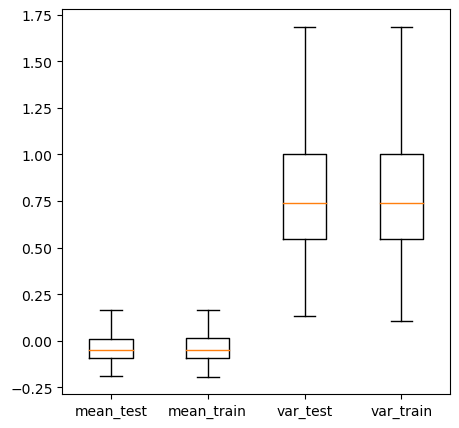

In [34]:
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['mean_test', 'mean_train', 
                    'var_test', 'var_train'])

 
# Creating plot
bp = ax.boxplot(data, showfliers=False)